# Mapping NLP Research Trends: Analysing and Clustering Paper Abstracts
by Vladimir Nikonov

This project involves collecting 1000 research paper abstracts related to NLP from arXiv, preprocessing the text data, and applying state‐of‐the-art NLP and ML techniques to perform clustering and topic modelling.


In [74]:
# Set up the environment
import numpy as np
import pandas as pd
import arxiv

import spacy
import spacy_cleaner
from spacy_cleaner.processing import removers, mutators

from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans

import umap.umap_ as umap
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import plotly.express as px

from bertopic import BERTopic

## 1. Data Collection and Preprocessing

### 1.1. Data Collection

Using the arXiv API (via the Python `arxiv` package) to fetch paper abstracts related to NLP.

In [2]:
# Construct the default API client.
client = arxiv.Client()

# Query arXiv for papers related to NLP
search = arxiv.Search(
    query="NLP",
    max_results=1000,
    sort_by=arxiv.SortCriterion.SubmittedDate
)

# Extract relevant fields: title, abstract, publication date
records = []
for result in client.results(search):
    records.append({
        "title": result.title,
        "abstract": result.summary,
        "published": result.published
    })

# Create a dataframe with the query results
df = pd.DataFrame(records)
df.head()

title  \
0  Accuracy is Not Agreement: Expert-Aligned Eval...   
1  Automated Generation of Commit Messages in Sof...   
2  SMARTe: Slot-based Method for Accountable Rela...   
3  Incorporating a Deep Neural Network into Movin...   
4  Self-Supervised Pre-training with Combined Dat...   

                                            abstract                 published  
0  This study explores the relationship between d... 2025-04-17 16:29:08+00:00  
1  Commit messages are crucial for documenting so... 2025-04-17 15:08:05+00:00  
2  Relational Triple Extraction (RTE) is a fundam... 2025-04-17 10:21:15+00:00  
3  This study introduces a novel state estimation... 2025-04-17 08:24:32+00:00  
4  The significant achievements of pre-trained mo... 2025-04-17 07:26:11+00:00

In [3]:
# Check the df size and nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   title      1000 non-null   object             
 1   abstract   1000 non-null   object             
 2   published  1000 non-null   datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), object(2)
memory usage: 23.6+ KB


In [4]:
# Save the df into a .csv file
df.to_csv("nlp_papers.csv", index=False)

### 1.2. Data Preprocessing
Using `spacy_cleaner` to clean the text data to remove noise – punctuation and stopwords – and apply lemmatization.

In [5]:
# Load SpaCy's small model for English
model = spacy.load("en_core_web_sm")

# Initialize the cleaner
cleaner = spacy_cleaner.Cleaner(
    model,
    removers.remove_stopword_token,
    removers.remove_punctuation_token,
    mutators.mutate_lemma_token,
)

In [6]:
# Storing the preprocessed abstracts in the clean_abstract column
df['clean_abstract'] = cleaner.clean(df['abstract'])

df.head()

Cleaning Progress: 100%|████████████████████████████████████████| 1000/1000 [00:26<00:00, 38.35it/s]


title  \
0  Accuracy is Not Agreement: Expert-Aligned Eval...   
1  Automated Generation of Commit Messages in Sof...   
2  SMARTe: Slot-based Method for Accountable Rela...   
3  Incorporating a Deep Neural Network into Movin...   
4  Self-Supervised Pre-training with Combined Dat...   

                                            abstract  \
0  This study explores the relationship between d...   
1  Commit messages are crucial for documenting so...   
2  Relational Triple Extraction (RTE) is a fundam...   
3  This study introduces a novel state estimation...   
4  The significant achievements of pre-trained mo...   

                  published                                     clean_abstract  
0 2025-04-17 16:29:08+00:00  study explore relationship deep learning DL mo...  
1 2025-04-17 15:08:05+00:00  commit message crucial document software chang...  
2 2025-04-17 10:21:15+00:00  Relational Triple Extraction RTE fundamental t...  
3 2025-04-17 08:24:32+00:00  study introduce novel state estimation framewo...  
4 2025-04-17 07:26:11+00:00  significant achievement pre train model levera...

In [7]:
# Displaying a few clean abstracts to check
list(df['clean_abstract'].head())

['study explore relationship deep learning DL model accuracy expert agreement classification crash narrative evaluate DL model include BERT variant Universal Sentence Encoder USE zero shot classifier expert label datum narrative text analysis extend large language model LLMs GPT-4 LLaMA 3 Qwen Claude result reveal counterintuitive trend model high technical accuracy exhibit low agreement domain expert llm demonstrate great expert alignment despite relatively low accuracy score quantify interpret model expert agreement employ Cohen Kappa Principal Component Analysis PCA shap base explainability technique finding indicate expert align model tend rely contextual temporal language cue location specific keyword result underscore accuracy insufficient evaluate model safety critical nlp application advocate incorporate expert agreement complementary metric model evaluation framework highlight promise llm interpretable scalable tool crash analysis pipeline',
 'commit message crucial document s

In [8]:
# Save the clean df into a .csv file
df.to_csv("nlp_papers_clean.csv", index=False)

After the first stage, we have a cleaned dataset of abstracts ready for analysis and modelling.

## 2. Abstract Clustering and Topic Modelling

### 2.1. Embedding Generation
Using the `SentenceTransformer` model to convert each abstract into a semantic embedding. This will allow us to cluster the documents in the next step. The lightweight `all-MiniLM-L6-v2` model is used for a quicker setup.

In [10]:
# Initialize the SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings for the cleaned abstracts
abstracts = df['clean_abstract'].tolist()
embeddings = model.encode(abstracts)

In [11]:
# Save the embeddings into a .npy file
np.save("embeddings.npy", embeddings)

### 2.2. Clustering the Embeddings
Applying K-Means to group similar abstracts.

In [12]:
# Initiating the K-Means
kmeans = KMeans(n_clusters=5, max_iter=100, random_state=42)    # A random n_clusters for now
clusters = kmeans.fit_predict(embeddings)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [13]:
# Add clusters to the df
df['cluster_5'] = clusters

# Save the clustered df as a .csv file
df.to_csv("nlp_papers_clustered.csv", index=False)

### 2.3. Cluster Visualisation
Plotting the clusters with `matplotlib.pyplot`.

In [78]:
# Apply UMAP to reduce the high-dimensional embeddings down to 2 dimensions for easier visualisation
reducer = umap.UMAP(random_state=42)
embeddings_2d = reducer.fit_transform(embeddings)

# Add UMAP results to the df
df['umap_x'] = embeddings_2d[:, 0]
df['umap_y'] = embeddings_2d[:, 1]

df.head()

title  \
0  Accuracy is Not Agreement: Expert-Aligned Eval...   
1  Automated Generation of Commit Messages in Sof...   
2  SMARTe: Slot-based Method for Accountable Rela...   
3  Incorporating a Deep Neural Network into Movin...   
4  Self-Supervised Pre-training with Combined Dat...   

                                            abstract  \
0  This study explores the relationship between d...   
1  Commit messages are crucial for documenting so...   
2  Relational Triple Extraction (RTE) is a fundam...   
3  This study introduces a novel state estimation...   
4  The significant achievements of pre-trained mo...   

                  published  \
0 2025-04-17 16:29:08+00:00   
1 2025-04-17 15:08:05+00:00   
2 2025-04-17 10:21:15+00:00   
3 2025-04-17 08:24:32+00:00   
4 2025-04-17 07:26:11+00:00   

                                      clean_abstract  cluster_5    umap_x  \
0  study explore relationship deep learning DL mo...          1  8.456847   
1  commit message crucial document software chang...          0  8.121341   
2  Relational Triple Extraction RTE fundamental t...          1  7.440807   
3  study introduce novel state estimation framewo...          3  9.429336   
4  significant achievement pre train model levera...          3  9.909652   

     umap_y  cluster_19  topic_5               topic_5_name  \
0  7.270626           3       -1  -1_model_language_llm_nlp   
1  7.311806           8        0  0_model_language_task_nlp   
2  9.727509           1       -1  -1_model_language_llm_nlp   
3  6.130569          17       -1  -1_model_language_llm_nlp   
4  5.682611           5        0  0_model_language_task_nlp   

                                   topic_5_top_words  topic_19  \
0  model - language - llm - nlp - task - performa...        -1   
1  model - language - task - nlp - llm - performa...        13   
2  model - language - llm - nlp - task - performa...        -1   
3  model - language - llm - nlp - task - performa...        -1   
4  model - language - task - nlp - llm - performa...        10   

                  topic_19_name  \
0     -1_model_language_llm_nlp   
1       13_code_software_ai_llm   
2     -1_model_language_llm_nlp   
3     -1_model_language_llm_nlp   
4  10_image_vision_visual_video   

                                  topic_19_top_words  
0  model - language - llm - nlp - task - large - ...  
1  code - software - ai - llm - testing - model -...  
2  model - language - llm - nlp - task - large - ...  
3  model - language - llm - nlp - task - large - ...  
4  image - vision - visual - video - autoregressi...

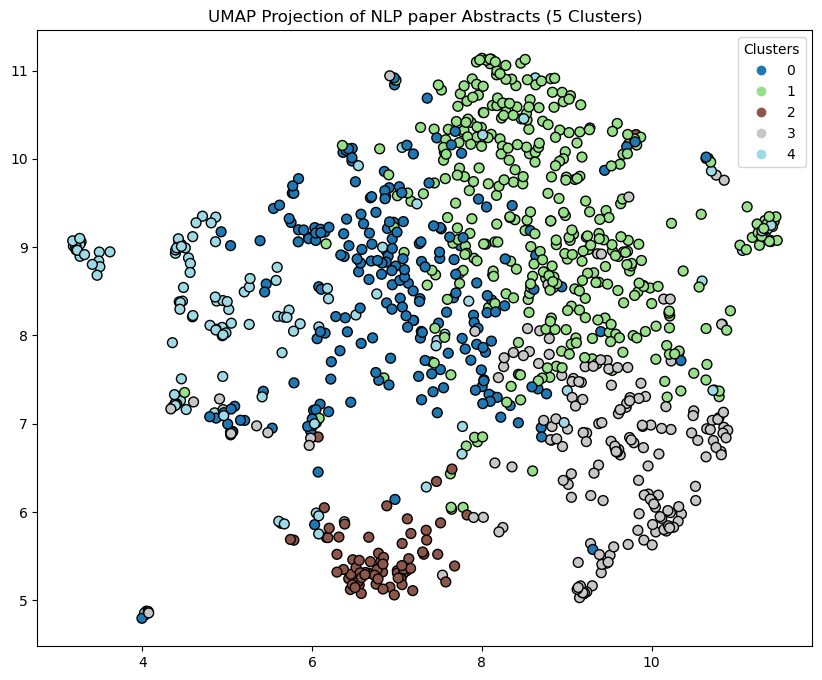

In [15]:
# Plot the clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(df['umap_x'], df['umap_y'], 
                      c=df['cluster_5'], cmap='tab20', 
                      s=50, edgecolors='black')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.title("UMAP Projection of NLP paper Abstracts (5 Clusters)")
plt.show()

Even though the clusters overlap, they are quite distinct. Especially cluster 2. 

Let's implement the elbow method to find an optimal number of clusters.

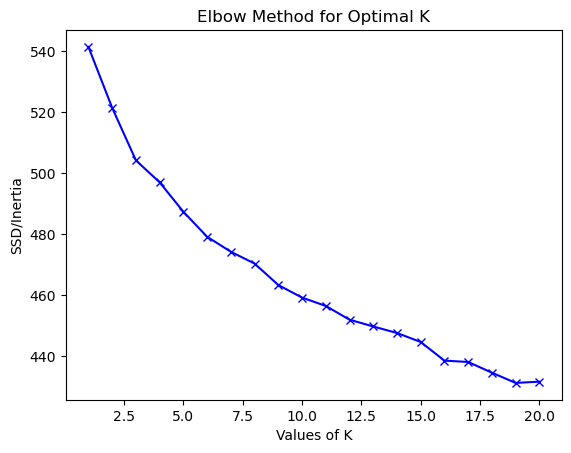

In [16]:
# Initiating the K-Means
ssd = []    # Sum of squared distances
K = range(1, 21)
for num_clusters in K:
    kmeans = KMeans(n_clusters= num_clusters, max_iter=100, random_state=42)
    kmeans.fit_predict(embeddings)
    ssd.append(kmeans.inertia_)

# Plotting
plt.plot(K, ssd, 'bx-')
plt.xlabel("Values of K")
plt.ylabel("SSD/Inertia")
plt.title("Elbow Method for Optimal K")
plt.show()

19 looks like an optimal number of clusters. Seems reasonable, considering the variety of topics in NLP research.

Let us plot the 2D embeddings with 19 clusters.

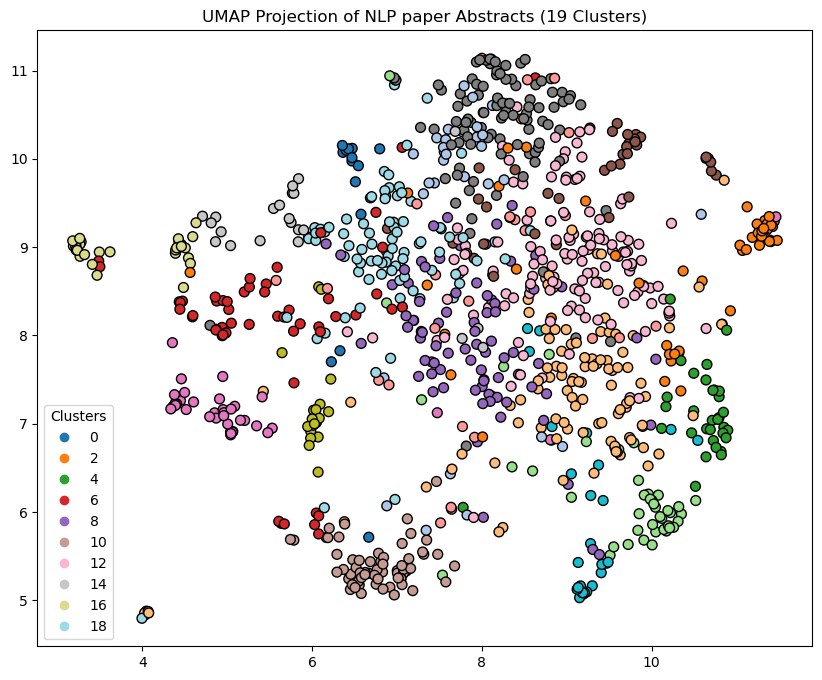

In [17]:
# Initiating the K-Means
kmeans = KMeans(n_clusters=19, max_iter=100, random_state=42)    # An increased n_clusters
clusters = kmeans.fit_predict(embeddings)

# Add clusters to the df
df['cluster_19'] = clusters

# Save the clustered df as a .csv file
df.to_csv("nlp_papers_clustered.csv", index=False)

# Plot the clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(df['umap_x'], df['umap_y'], 
                      c=df['cluster_19'], cmap='tab20', 
                      s=50, edgecolors='black')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.title("UMAP Projection of NLP paper Abstracts (19 Clusters)")
plt.show()

Now, there are more distinct clusters, some of them are quite spread out, some overlap, but many groups of observations can be seen. Cluster 10 seems quite like cluster 2 from the 5-cluster plot.

Let us see the value counts for them.

In [19]:
print(df['cluster_5'][df['cluster_5']==2].count(), "observations in cluster 2/5")
print(df['cluster_19'][df['cluster_19']==10].count(), "observations in cluster 10/19")

73 observations in cluster 2/5
62 observations in cluster 10/19


The number of observations in the clusters differs by 11.

Topic modelling might provide some insights into the clusters.

### 2.4. Topic Modelling

Using BERTopic to extract topics from clusters.

First, let us extract 5 topics, and then 19.

In [26]:
# Fit BERTopic on the cleaned abstracts
topic_model_5 = BERTopic(nr_topics=5)
topics, probs = topic_model_5.fit_transform(df['clean_abstract'].tolist())

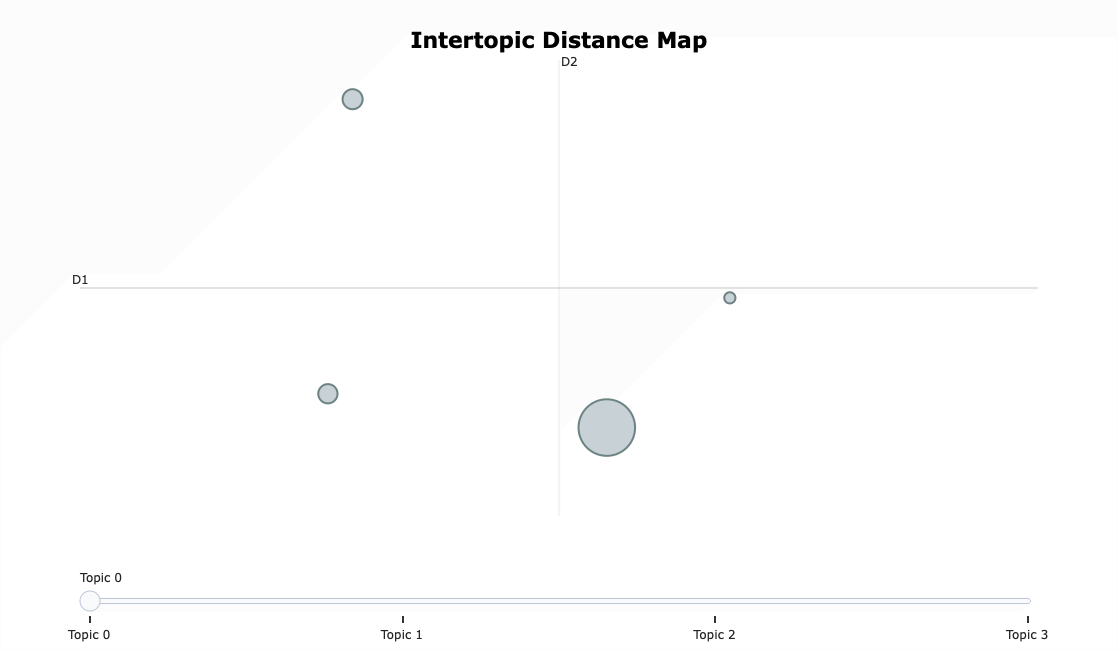

In [79]:
# Visualising the topics
topic_model_5.visualize_topics()

In [28]:
# Getting the topics info
topic_model_5.get_document_info(df['clean_abstract'])

Document  Topic  \
0    study explore relationship deep learning DL mo...     -1   
1    commit message crucial document software chang...      0   
2    Relational Triple Extraction RTE fundamental t...     -1   
3    study introduce novel state estimation framewo...     -1   
4    significant achievement pre train model levera...      0   
..                                                 ...    ...   
995  build relevance model rank document base user ...      0   
996  challenging problem face NLP today evaluation ...     -1   
997  recent advance natural language processing NLP...      0   
998  rapid growth social medium usage common trend ...      1   
999  limited public understanding legal process inc...      0   

                                     Name  \
0               -1_model_language_llm_nlp   
1               0_model_language_task_nlp   
2               -1_model_language_llm_nlp   
3               -1_model_language_llm_nlp   
4               0_model_language_task_nlp   
..                                    ...   
995             0_model_language_task_nlp   
996             -1_model_language_llm_nlp   
997             0_model_language_task_nlp   
998  1_emotion_sentiment_language_dataset   
999             0_model_language_task_nlp   

                                        Representation  \
0    [model, language, llm, nlp, task, performance,...   
1    [model, language, task, nlp, llm, performance,...   
2    [model, language, llm, nlp, task, performance,...   
3    [model, language, llm, nlp, task, performance,...   
4    [model, language, task, nlp, llm, performance,...   
..                                                 ...   
995  [model, language, task, nlp, llm, performance,...   
996  [model, language, llm, nlp, task, performance,...   
997  [model, language, task, nlp, llm, performance,...   
998  [emotion, sentiment, language, dataset, model,...   
999  [model, language, task, nlp, llm, performance,...   

                                   Representative_Docs  \
0    [rapid development Natural Language Processing...   
1    [artificial intelligence system significantly ...   
2    [rapid development Natural Language Processing...   
3    [rapid development Natural Language Processing...   
4    [artificial intelligence system significantly ...   
..                                                 ...   
995  [artificial intelligence system significantly ...   
996  [rapid development Natural Language Processing...   
997  [artificial intelligence system significantly ...   
998  [understand emotion express language vital bui...   
999  [artificial intelligence system significantly ...   

                                           Top_n_words  Probability  \
0    model - language - llm - nlp - task - performa...     0.000000   
1    model - language - task - nlp - llm - performa...     1.000000   
2    model - language - llm - nlp - task - performa...     0.000000   
3    model - language - llm - nlp - task - performa...     0.000000   
4    model - language - task - nlp - llm - performa...     0.580947   
..                                                 ...          ...   
995  model - language - task - nlp - llm - performa...     1.000000   
996  model - language - llm - nlp - task - performa...     0.000000   
997  model - language - task - nlp - llm - performa...     0.867057   
998  emotion - sentiment - language - dataset - mod...     0.880688   
999  model - language - task - nlp - llm - performa...     0.814599   

     Representative_document  
0                      False  
1                      False  
2                      False  
3                      False  
4                      False  
..                       ...  
995                    False  
996                    False  
997                    False  
998                    False  
999                    False  

[1000 rows x 8 columns]

In [34]:
# Adding topics, their names, and top words into the df
df['topic_5'] = topics
df['topic_5_name'] = topic_model_5.get_document_info(df['clean_abstract'])['Name']
df['topic_5_top_words'] = topic_model_5.get_document_info(df['clean_abstract'])['Top_n_words']

df.head()

title  \
0  Accuracy is Not Agreement: Expert-Aligned Eval...   
1  Automated Generation of Commit Messages in Sof...   
2  SMARTe: Slot-based Method for Accountable Rela...   
3  Incorporating a Deep Neural Network into Movin...   
4  Self-Supervised Pre-training with Combined Dat...   

                                            abstract  \
0  This study explores the relationship between d...   
1  Commit messages are crucial for documenting so...   
2  Relational Triple Extraction (RTE) is a fundam...   
3  This study introduces a novel state estimation...   
4  The significant achievements of pre-trained mo...   

                  published  \
0 2025-04-17 16:29:08+00:00   
1 2025-04-17 15:08:05+00:00   
2 2025-04-17 10:21:15+00:00   
3 2025-04-17 08:24:32+00:00   
4 2025-04-17 07:26:11+00:00   

                                      clean_abstract  cluster_5    umap_x  \
0  study explore relationship deep learning DL mo...          1  8.456847   
1  commit message crucial document software chang...          0  8.121341   
2  Relational Triple Extraction RTE fundamental t...          1  7.440807   
3  study introduce novel state estimation framewo...          3  9.429336   
4  significant achievement pre train model levera...          3  9.909652   

     umap_y  cluster_19  topic_5               topic_5_name  \
0  7.270626           3       -1  -1_model_language_llm_nlp   
1  7.311806           8        0  0_model_language_task_nlp   
2  9.727509           1       -1  -1_model_language_llm_nlp   
3  6.130569          17       -1  -1_model_language_llm_nlp   
4  5.682611           5        0  0_model_language_task_nlp   

                                   topic_5_top_words  
0  model - language - llm - nlp - task - performa...  
1  model - language - task - nlp - llm - performa...  
2  model - language - llm - nlp - task - performa...  
3  model - language - llm - nlp - task - performa...  
4  model - language - task - nlp - llm - performa...

In [31]:
# Get the topics info
topic_model_5.get_topic_info()

Topic  Count                                  Name  \
0     -1    348             -1_model_language_llm_nlp   
1      0    509             0_model_language_task_nlp   
2      1     64  1_emotion_sentiment_language_dataset   
3      2     59    2_attack_privacy_model_adversarial   
4      3     20  3_problem_nonlinear_robot_trajectory   

                                      Representation  \
0  [model, language, llm, nlp, task, performance,...   
1  [model, language, task, nlp, llm, performance,...   
2  [emotion, sentiment, language, dataset, model,...   
3  [attack, privacy, model, adversarial, nlp, lan...   
4  [problem, nonlinear, robot, trajectory, algori...   

                                 Representative_Docs  
0  [rapid development Natural Language Processing...  
1  [artificial intelligence system significantly ...  
2  [understand emotion express language vital bui...  
3  [recent year large language model LLMs signifi...  
4  [optimal control switch base dynamical system ...

In [35]:
# Check the value counts of topics top words
df['topic_5_top_words'].value_counts()

topic_5_top_words
model - language - task - nlp - llm - performance - base - datum - method - dataset                        509
model - language - llm - nlp - task - performance - datum - large - dataset - base                         348
emotion - sentiment - language - dataset - model - analysis - detection - social - nlp - content            64
attack - privacy - model - adversarial - nlp - language - method - approach - base - backdoor               59
problem - nonlinear - robot - trajectory - algorithm - solve - solution - constraint - object - propose     20
Name: count, dtype: int64

- The largest topic (topic 0) is related to LLMs in general, according to its representations.
- Looks like topic 1 (count 64) is related to sentiment analysis and emotion detection.
- The third largest topic (topic 2) appears to be related to privacy.
- The fourth topic (topic 3) seems to be in the area of implementing LLMs in robotics.
- The unassigned topic (-1) is almost identical to topic 0.

Let us see if the number of observations in the clusters and in the topics is close.

In [36]:
print(df['cluster_5'].value_counts())
print(df['topic_5'].value_counts())

cluster_5
1    384
0    238
3    178
4    127
2     73
Name: count, dtype: int64
topic_5
 0    509
-1    348
 1     64
 2     59
 3     20
Name: count, dtype: int64


Not exactly. Some observations might fall into the same clusters and topics. This will be seen in the visualisation later.

Now, let us extract 19 topics, the same as the optimal cluster number.

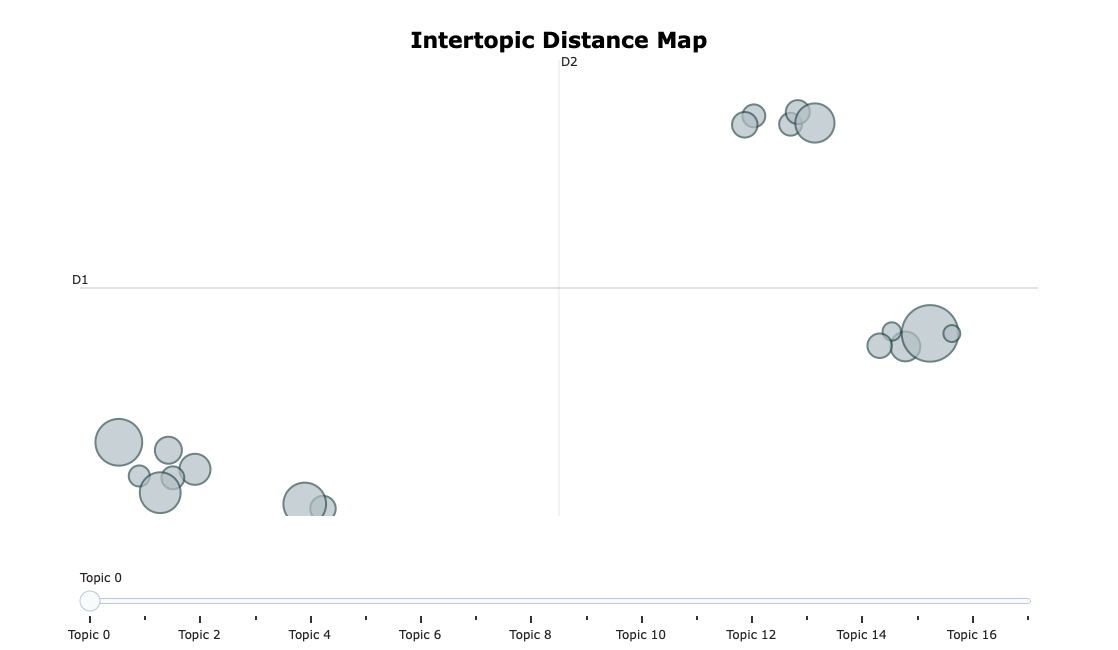

In [38]:
# Fit BERTopic on the cleaned abstracts
topic_model_19 = BERTopic(nr_topics=19)
topic_model_19.fit_transform(df['clean_abstract'].tolist())

# Visualizing the topics
topic_model_19.visualize_topics()

Topic  Count                                         Name  \
0      -1    305                    -1_model_language_llm_nlp   
1       0     34             0_embedding_embed_model_sentence   
2       1     20           1_emotion_emotional_label_language   
3       2     37          2_attack_adversarial_model_backdoor   
4       3     84                 3_clinical_medical_model_nlp   
5       4     20          4_content_hate_moderation_detection   
6       5     22          5_sentiment_analysis_model_customer   
7       6     25                       6_privacy_dp_nlp_model   
8       7     13                7_model_transformer_base_bert   
9       8    123                8_language_resource_model_nlp   
10      9     17               9_retrieval_rag_query_document   
11     10     28                 10_image_vision_visual_video   
12     11     20        11_problem_nonlinear_robot_trajectory   
13     12     23  12_transformer_attention_architecture_model   
14     13     25                      13_code_software_ai_llm   
15     14     11            14_legal_contract_document_clause   
16     15     59           15_summarization_text_nlp_research   
17     16     64                     16_model_task_datum_fine   
18     17     70                   17_llm_task_llms_reasoning   

                                       Representation  \
0   [model, language, llm, nlp, task, large, perfo...   
1   [embedding, embed, model, sentence, text, task...   
2   [emotion, emotional, label, language, dataset,...   
3   [attack, adversarial, model, backdoor, securit...   
4   [clinical, medical, model, nlp, health, study,...   
5   [content, hate, moderation, detection, speech,...   
6   [sentiment, analysis, model, customer, sa, cla...   
7   [privacy, dp, nlp, model, pii, help, policy, l...   
8   [model, transformer, base, bert, task, archite...   
9   [language, resource, model, nlp, multilingual,...   
10  [retrieval, rag, query, document, persian, mod...   
11  [image, vision, visual, video, autoregressive,...   
12  [problem, nonlinear, robot, trajectory, algori...   
13  [transformer, attention, architecture, model, ...   
14  [code, software, ai, llm, testing, model, test...   
15  [legal, contract, document, clause, retrieval,...   
16  [summarization, text, nlp, research, review, a...   
17  [model, task, datum, fine, performance, traini...   
18  [llm, task, llms, reasoning, context, long, la...   

                                  Representative_Docs  
0   [large language model LLMs play crucial role n...  
1   [embed inversion i.e. reconstruct text give em...  
2   [understand emotion express language vital bui...  
3   [rapid growth natural language processing NLP ...  
4   [objective review aim analyze application natu...  
5   [effective toxic content detection rely heavil...  
6   [Sentiment Analysis SA opinion mining analysis...  
7   [pretraine fine tuning approach lead technique...  
8   [encoder model BERT modernbert ubiquitous real...  
9   [memoir explore fundamental aspect Natural Lan...  
10  [retrieval augment generation RAG model integr...  
11  [autoregressive modeling huge success field na...  
12  [optimal control switch base dynamical system ...  
13  [transformer architecture underpin self attent...  
14  [owe exceptional performance large Language Mo...  
15  [limited public understanding legal process in...  
16  [automatic patent summarization approach help ...  
17  [NLP Zero Shot Classification ZSC essential en...  
18  [large language model LLMs base Transformer wi...

In [45]:
# Adding topics, their names, and top words into the df
df['topic_19'] = topic_model_19.get_document_info(df['clean_abstract'])['Topic']
df['topic_19_name'] = topic_model_19.get_document_info(df['clean_abstract'])['Name']
df['topic_19_top_words'] = topic_model_19.get_document_info(df['clean_abstract'])['Top_n_words']

df.head()

title  \
0  Accuracy is Not Agreement: Expert-Aligned Eval...   
1  Automated Generation of Commit Messages in Sof...   
2  SMARTe: Slot-based Method for Accountable Rela...   
3  Incorporating a Deep Neural Network into Movin...   
4  Self-Supervised Pre-training with Combined Dat...   

                                            abstract  \
0  This study explores the relationship between d...   
1  Commit messages are crucial for documenting so...   
2  Relational Triple Extraction (RTE) is a fundam...   
3  This study introduces a novel state estimation...   
4  The significant achievements of pre-trained mo...   

                  published  \
0 2025-04-17 16:29:08+00:00   
1 2025-04-17 15:08:05+00:00   
2 2025-04-17 10:21:15+00:00   
3 2025-04-17 08:24:32+00:00   
4 2025-04-17 07:26:11+00:00   

                                      clean_abstract  cluster_5    umap_x  \
0  study explore relationship deep learning DL mo...          1  8.456847   
1  commit message crucial document software chang...          0  8.121341   
2  Relational Triple Extraction RTE fundamental t...          1  7.440807   
3  study introduce novel state estimation framewo...          3  9.429336   
4  significant achievement pre train model levera...          3  9.909652   

     umap_y  cluster_19  topic_5               topic_5_name  \
0  7.270626           3       -1  -1_model_language_llm_nlp   
1  7.311806           8        0  0_model_language_task_nlp   
2  9.727509           1       -1  -1_model_language_llm_nlp   
3  6.130569          17       -1  -1_model_language_llm_nlp   
4  5.682611           5        0  0_model_language_task_nlp   

                                   topic_5_top_words  topic_19  \
0  model - language - llm - nlp - task - performa...        -1   
1  model - language - task - nlp - llm - performa...        13   
2  model - language - llm - nlp - task - performa...        -1   
3  model - language - llm - nlp - task - performa...        -1   
4  model - language - task - nlp - llm - performa...        10   

                  topic_19_name  \
0     -1_model_language_llm_nlp   
1       13_code_software_ai_llm   
2     -1_model_language_llm_nlp   
3     -1_model_language_llm_nlp   
4  10_image_vision_visual_video   

                                  topic_19_top_words  
0  model - language - llm - nlp - task - large - ...  
1  code - software - ai - llm - testing - model -...  
2  model - language - llm - nlp - task - large - ...  
3  model - language - llm - nlp - task - large - ...  
4  image - vision - visual - video - autoregressi...

In [73]:
# Get the topics info
topic_model_19.get_topic_info()

Topic  Count                                         Name  \
0      -1    305                    -1_model_language_llm_nlp   
1       0     34             0_embedding_embed_model_sentence   
2       1     20           1_emotion_emotional_label_language   
3       2     37          2_attack_adversarial_model_backdoor   
4       3     84                 3_clinical_medical_model_nlp   
5       4     20          4_content_hate_moderation_detection   
6       5     22          5_sentiment_analysis_model_customer   
7       6     25                       6_privacy_dp_nlp_model   
8       7     13                7_model_transformer_base_bert   
9       8    123                8_language_resource_model_nlp   
10      9     17               9_retrieval_rag_query_document   
11     10     28                 10_image_vision_visual_video   
12     11     20        11_problem_nonlinear_robot_trajectory   
13     12     23  12_transformer_attention_architecture_model   
14     13     25                      13_code_software_ai_llm   
15     14     11            14_legal_contract_document_clause   
16     15     59           15_summarization_text_nlp_research   
17     16     64                     16_model_task_datum_fine   
18     17     70                   17_llm_task_llms_reasoning   

                                       Representation  \
0   [model, language, llm, nlp, task, large, perfo...   
1   [embedding, embed, model, sentence, text, task...   
2   [emotion, emotional, label, language, dataset,...   
3   [attack, adversarial, model, backdoor, securit...   
4   [clinical, medical, model, nlp, health, study,...   
5   [content, hate, moderation, detection, speech,...   
6   [sentiment, analysis, model, customer, sa, cla...   
7   [privacy, dp, nlp, model, pii, help, policy, l...   
8   [model, transformer, base, bert, task, archite...   
9   [language, resource, model, nlp, multilingual,...   
10  [retrieval, rag, query, document, persian, mod...   
11  [image, vision, visual, video, autoregressive,...   
12  [problem, nonlinear, robot, trajectory, algori...   
13  [transformer, attention, architecture, model, ...   
14  [code, software, ai, llm, testing, model, test...   
15  [legal, contract, document, clause, retrieval,...   
16  [summarization, text, nlp, research, review, a...   
17  [model, task, datum, fine, performance, traini...   
18  [llm, task, llms, reasoning, context, long, la...   

                                  Representative_Docs  
0   [large language model LLMs play crucial role n...  
1   [embed inversion i.e. reconstruct text give em...  
2   [understand emotion express language vital bui...  
3   [rapid growth natural language processing NLP ...  
4   [objective review aim analyze application natu...  
5   [effective toxic content detection rely heavil...  
6   [Sentiment Analysis SA opinion mining analysis...  
7   [pretraine fine tuning approach lead technique...  
8   [encoder model BERT modernbert ubiquitous real...  
9   [memoir explore fundamental aspect Natural Lan...  
10  [retrieval augment generation RAG model integr...  
11  [autoregressive modeling huge success field na...  
12  [optimal control switch base dynamical system ...  
13  [transformer architecture underpin self attent...  
14  [owe exceptional performance large Language Mo...  
15  [limited public understanding legal process in...  
16  [automatic patent summarization approach help ...  
17  [NLP Zero Shot Classification ZSC essential en...  
18  [large language model LLMs base Transformer wi...

In [42]:
# Check the value counts of topics top words
df['topic_19_top_words'].value_counts()

topic_19_top_words
model - language - llm - nlp - task - large - performance - base - natural - method                                       305
language - resource - model - nlp - multilingual - linguistic - low - dataset - task - translation                        123
clinical - medical - model - nlp - health - study - datum - patient - language - result                                    84
llm - task - llms - reasoning - context - long - language - model - performance - large                                    70
model - task - datum - fine - performance - training - learning - tuning - method - shot                                   64
summarization - text - nlp - research - review - approach - sustainability - paper - analysis - document                   59
attack - adversarial - model - backdoor - security - vulnerability - robustness - defense - threat - method                37
embedding - embed - model - sentence - text - task - user - word - semantic - representation       

- The papers in the largest group (topic 8) seem to address the problem of how language models perform in low-resourced languages and in multilingual settings, a growing trend in NLP research.

- Looks like the second largest topic (topic 3) is related to the use of language models in healthcare.

- Topic 17 appears to be on reasoning in LLMs.

- The fourth largest topic (topic 16) shows signs of being on fine-tuning language models.

Let us visualize 

In [112]:
# Save the df with topics
df.to_csv("nlp_papers_with topics.csv", index=False)

After stage 2, we have 19 clusters of abstracts and 19 topics (including the unassigned).

## 3. Interactive Dashboard with Plotly
Building an interactive scatter plot that allows the viewer to hover over points to see details, such as the title and publication date.

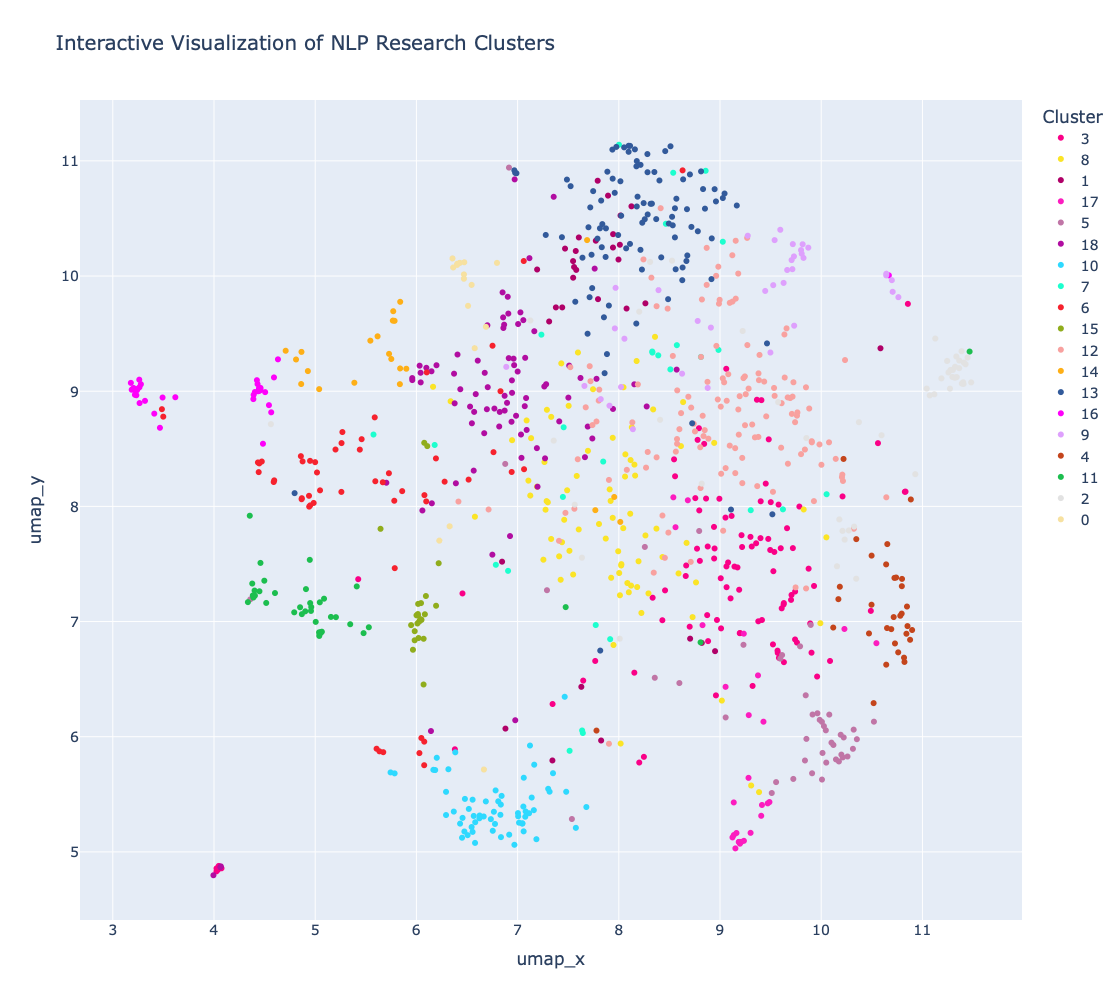

In [57]:
# Create an interactive scatter plot
fig = px.scatter(
    df,
    x='umap_x',
    y='umap_y',
    color=df['cluster_19'].astype(str),
    color_discrete_sequence=px.colors.qualitative.Alphabet_r,
    hover_data=['title', 
                'published', 
                'topic_19',
                'topic_19_top_words'],
    title="Interactive Visualization of NLP Research Clusters",
    width=1000,
    height=1000
)

fig.update_layout(
    legend_title_text='Cluster',
    font=dict(size=14),
)

fig.show()

After hovering over the visualization, it's clear that many of the observations in the same clusters have the same topics. To see how well they align with each other, let us use Pandas' `crosstab` to generate a contingency table. It will show how many papers in each topic fall into each cluster.

In [64]:
pd.crosstab(df['topic_19'], df['cluster_19'])

cluster_19  0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  \
topic_19                                                                     
-1           3  10  13  47   5  10  20  16  48  12   1   3  51  14   8   1   
 0           0   1  25   1   0   0   0   0   0   5   0   1   0   0   0   0   
 1           0   0   0   0   0   0   2   0   0   0   0   0   0   0   0   0   
 2           0   0   0   1   0   1   0   0   0   0   0  35   0   0   0   0   
 3           1   3   0   3   1   1   7   3   1   0  61   0   1   0   0   1   
 4           0   0   0   0   0   0  19   0   0   0   0   0   0   1   0   0   
 5           0   0   1   0   0   0   0   0   0   0   0   0   0   0   5   0   
 6           0   0   0   1   0   0   2   0   0   0   0   0   0   0   0  22   
 7           0   0   6   1   3   0   0   0   2   0   0   0   1   0   0   0   
 8           0  18   1   0   0   0   2   5   0   0   0   0  15  79   1   0   
 9           0   0   0   0   0   0   0   0   0  17   0   0   0   0   0   0   
 10          0   0   0   0   1  27   0   0   0   0   0   0   0   0   0   0   
 11          0   0   0   0   0   2   0   0   2   0   0   0   0   0   0   0   
 12          0   0   0   1  21   0   0   0   0   0   0   0   0   0   0   0   
 13          0   0   1   0   0   0   0   0  18   0   0   0   3   0   1   0   
 14         11   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
 15          1   0   1   0   0   0   1   0   4   1   0   0   0   0   7   0   
 16          0   0   0  44   0   4   0   2   1   0   0   0   8   2   0   0   
 17          0   0   1   4   1   0   0   2   4   2   0   0  55   1   0   0   

cluster_19  16  17  18  
topic_19                
-1           0   7  36  
 0           1   0   0  
 1          18   0   0  
 2           0   0   0  
 3           0   0   1  
 4           0   0   0  
 5          16   0   0  
 6           0   0   0  
 7           0   0   0  
 8           0   0   2  
 9           0   0   0  
 10          0   0   0  
 11          0  16   0  
 12          0   1   0  
 13          0   0   2  
 14          0   0   0  
 15          0   0  44  
 16          0   3   0  
 17          0   0   0

In the table, rows represent topics, and columns represent clusters.

The unassigned topic is completely random; there are papers from almost every cluster in it.

Here are the topics with dominant clusters and their number of papers.

In [69]:
ct = pd.crosstab(df['topic_19'], df['cluster_19'])

# Get the dominant cluster (column with max count) for each topic
dominant_cluster = ct.idxmax(axis=1)

# Get the number of papers in that dominant cluster
paper_count = ct.max(axis=1)

# Combine into a small summary dataframe
summary_df = pd.DataFrame({
    'topic_19': ct.index,
    'dominant_cluster': dominant_cluster.values,
    'paper_count': paper_count.values
}).reset_index(drop=True)

summary_df = summary_df.merge(
    df[['topic_19', 'topic_19_top_words']].drop_duplicates(),
    on='topic_19',
    how='left'
)

summary_df = summary_df.drop(0, axis=0).reset_index(drop=True)

summary_df

topic_19  dominant_cluster  paper_count  \
0          0                 2           25   
1          1                16           18   
2          2                11           35   
3          3                10           61   
4          4                 6           19   
5          5                16           16   
6          6                15           22   
7          7                 2            6   
8          8                13           79   
9          9                 9           17   
10        10                 5           27   
11        11                17           16   
12        12                 4           21   
13        13                 8           18   
14        14                 0           11   
15        15                18           44   
16        16                 3           44   
17        17                12           55   

                                   topic_19_top_words  
0   embedding - embed - model - sentence - text - ...  
1   emotion - emotional - label - language - datas...  
2   attack - adversarial - model - backdoor - secu...  
3   clinical - medical - model - nlp - health - st...  
4   content - hate - moderation - detection - spee...  
5   sentiment - analysis - model - customer - sa -...  
6   privacy - dp - nlp - model - pii - help - poli...  
7   model - transformer - base - bert - task - arc...  
8   language - resource - model - nlp - multilingu...  
9   retrieval - rag - query - document - persian -...  
10  image - vision - visual - video - autoregressi...  
11  problem - nonlinear - robot - trajectory - alg...  
12  transformer - attention - architecture - model...  
13  code - software - ai - llm - testing - model -...  
14  legal - contract - document - clause - retriev...  
15  summarization - text - nlp - research - review...  
16  model - task - datum - fine - performance - tr...  
17  llm - task - llms - reasoning - context - long...

Let us create word clouds for each topic using the cleaned abstracts. This will add more interpretability to the topics and the results.

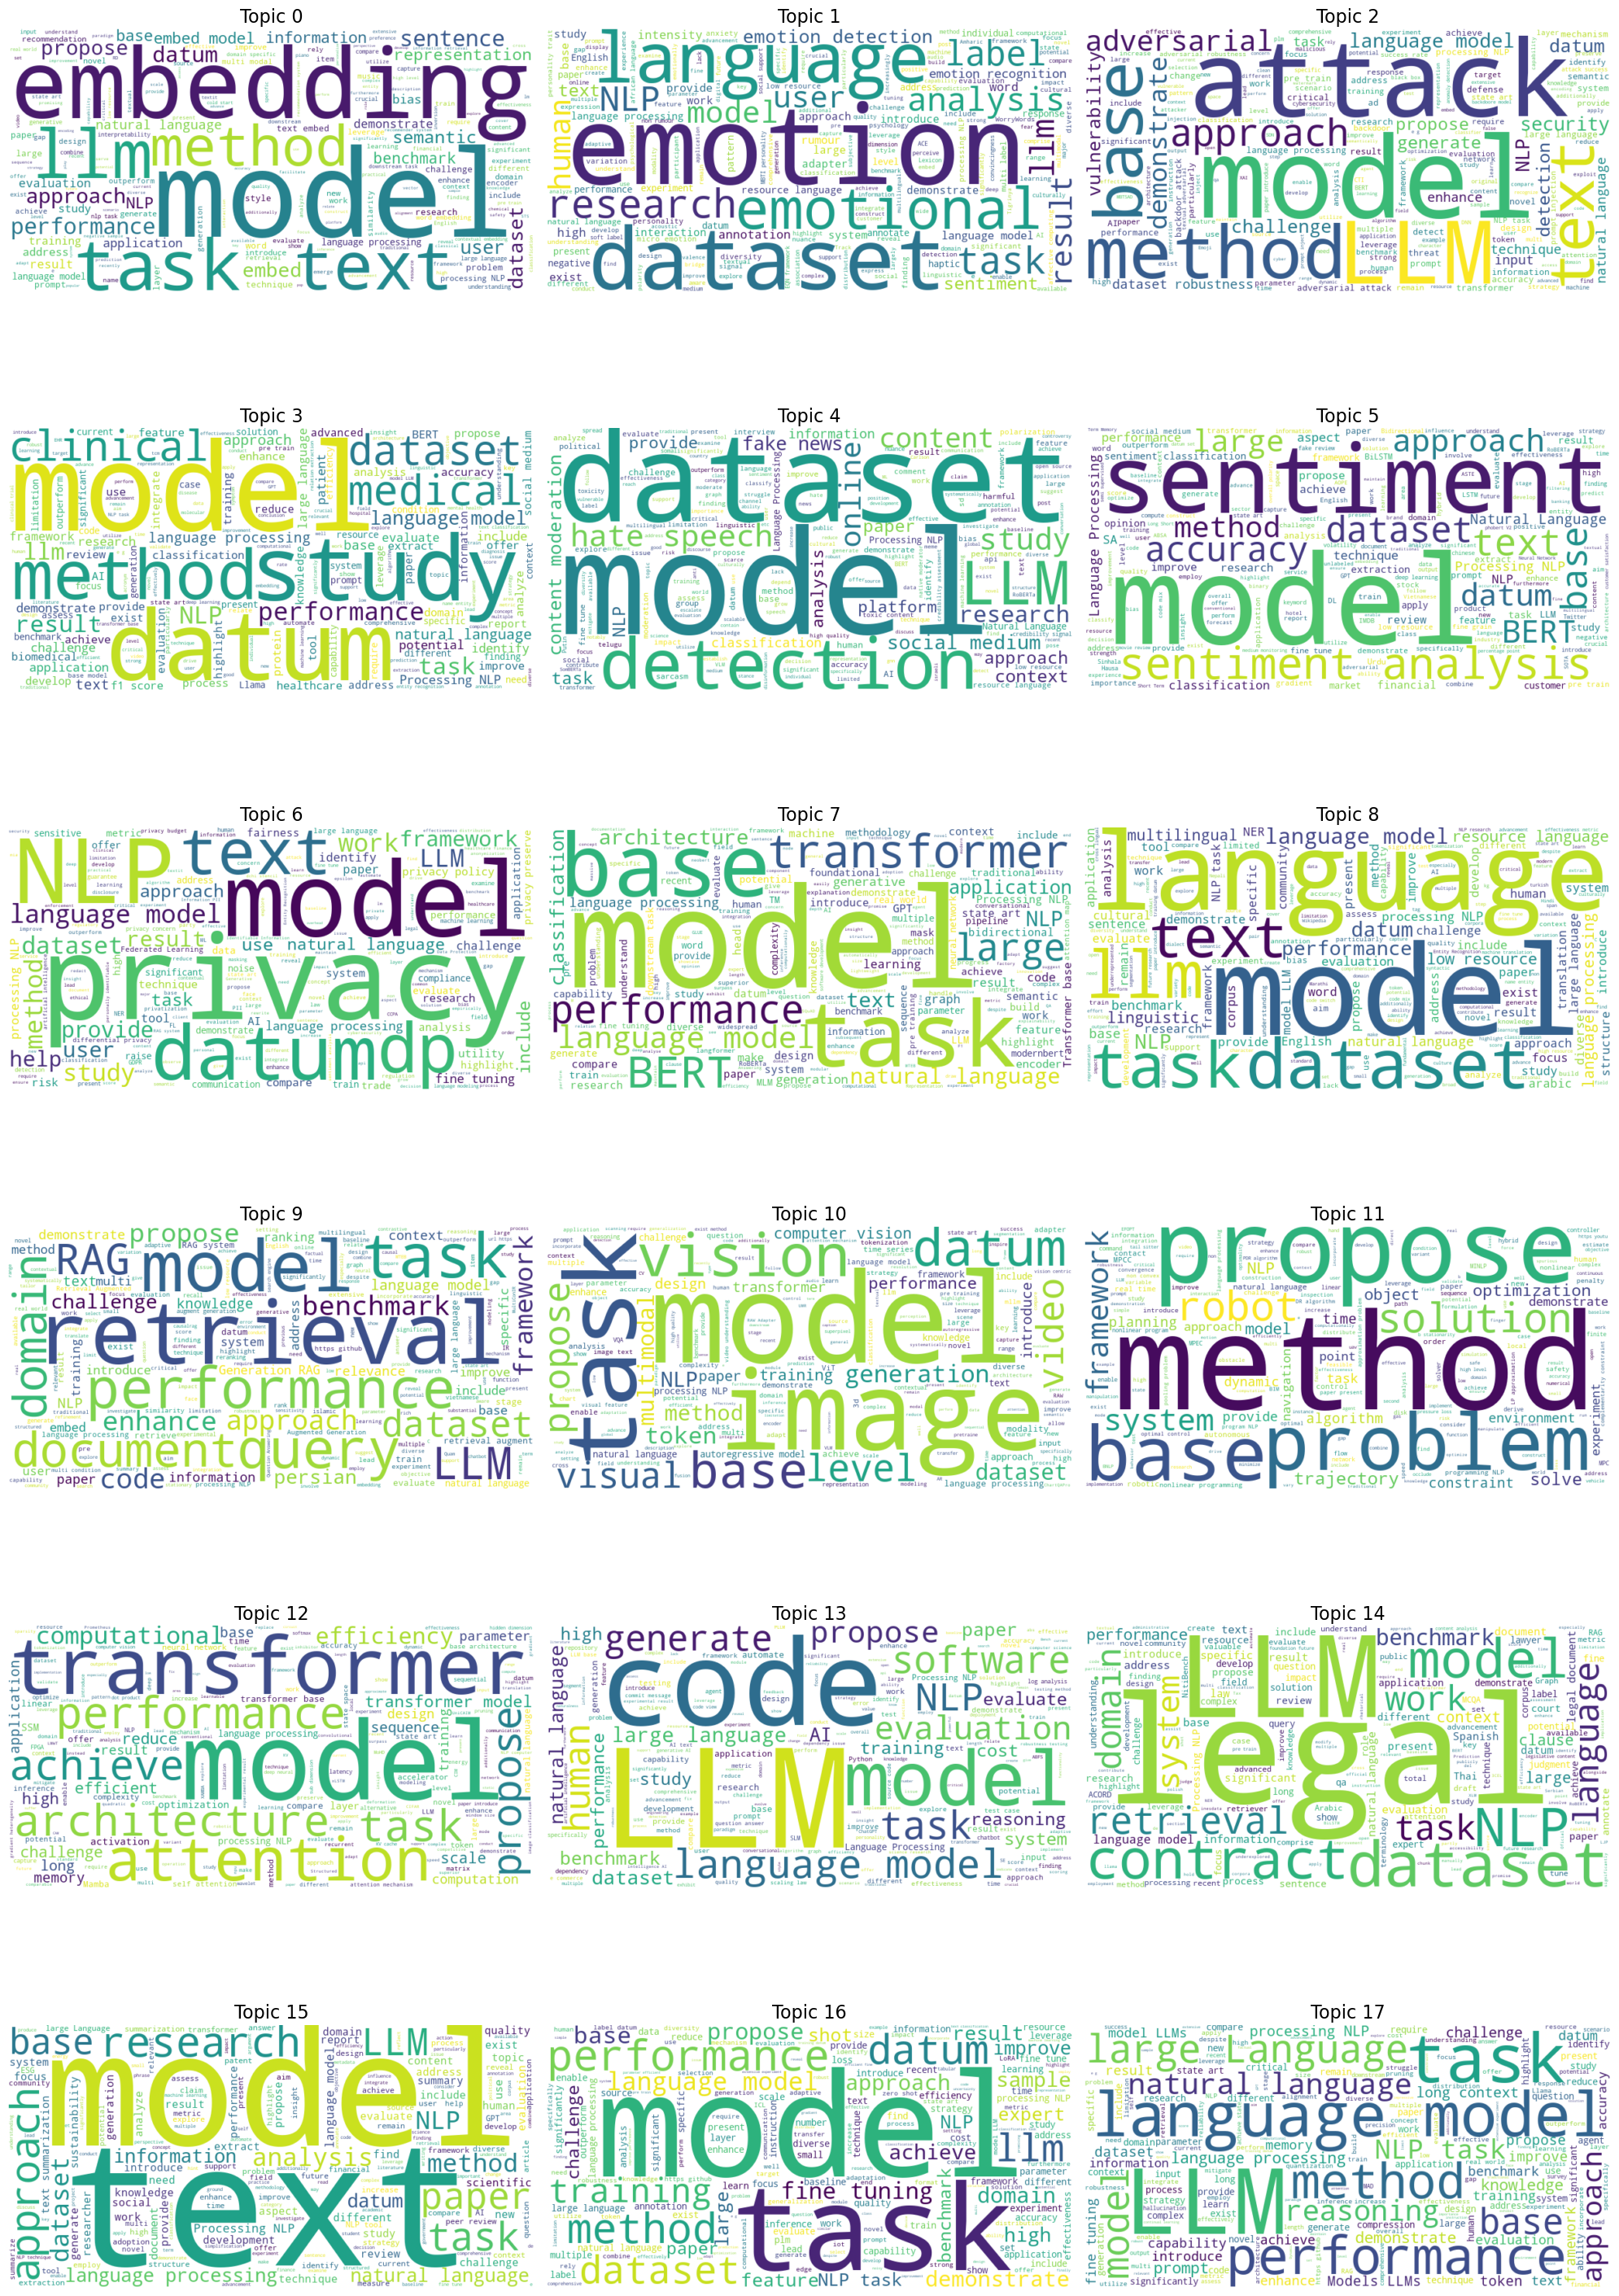

In [77]:
# Filter out unassigned topics (-1)
valid_df = df[df['topic_19'] != -1]

# Group abstracts by topic
topic_texts = valid_df.groupby('topic_19')['clean_abstract'].apply(lambda texts: ' '.join(texts))

# Plot setup
n_topics = topic_texts.shape[0]
cols = 3
rows = (n_topics // cols) + 1
plt.figure(figsize=(20, 5 * rows))

# Generate a word cloud for each topic
for i, (topic_id, text) in enumerate(topic_texts.items(), 1):
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.subplot(rows, cols, i)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Topic {topic_id}", fontsize=16)

plt.tight_layout()
plt.show()